In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
result = calc_temps('2016-08-01', '2017-08-01')
print(result)

[(58.0, 74.64288840262581, 87.0)]


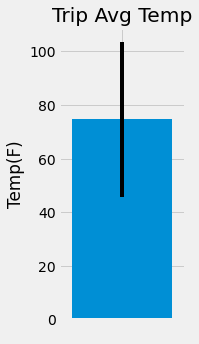

In [41]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(x=' ', height = result[0][1], yerr=(result[0][2]-result[0][0]))
plt.title("Trip Avg Temp")
plt.ylabel('Temp(F)')
plt.xlim(-0.5, 0.5)
plt.show()

### Daily Rainfall Average

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-08-01'
end_date = '2017-08-01'
rainfall = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[(1421.1899999999887,
  'USC00516128',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (715.4099999999972,
  'USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (489.50999999999704,
  'USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (358.19999999999976,
  'USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (308.33999999999986,
  'USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (154.80000000000078,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (42.92999999999995,
  'USC00517948',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0)]

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
'''start = dt.datetime.strptime(start_date, "%Y-%m-%d")
end = dt.datetime.strptime(end_date, "%Y-%m-%d")
date_generated = [start + dt.timedelta(days=x) for x in range(0, (end-start).days+1)]

date_generated'''

#dates = pd.date_range(start_date,end_date).to_list()
dates = [dt.datetime.strptime(end_date, "%Y-%m-%d") - dt.timedelta(days=x) for x in range(7)]
dates

# Strip off the year and save a list of strings in the format %m-%d
'''date_list=[]
for date in dates:
    date_list.append(func.strftime(date,"%m-%d"))
date_list'''
dates
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


[datetime.datetime(2017, 8, 7, 0, 0),
 datetime.datetime(2017, 8, 6, 0, 0),
 datetime.datetime(2017, 8, 5, 0, 0),
 datetime.datetime(2017, 8, 4, 0, 0),
 datetime.datetime(2017, 8, 3, 0, 0),
 datetime.datetime(2017, 8, 2, 0, 0),
 datetime.datetime(2017, 8, 1, 0, 0)]

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
session.close()